# load evaluation data

In [55]:
import json

def load_responses(path):
    data = []
    
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
            
    return data



In [56]:
from glob import glob
import pandas as pd


res_files = glob('data/eval4/*.json')

res_df_list = []

for f in res_files:
    model_name = f.split('/')[-1].replace(".json", "")
    correct = 0
    sra = 0
    resps = load_responses(f)
    for r in resps:
        if r['strategy'] == r['inferred_strategy']:
            correct += 1
        sra += r['sra']
    res_df_list.append({
        'acc': correct/len(resps),
        'model': model_name,
        'sra': sra/len(resps)
    })

df = pd.DataFrame(res_df_list)
df.sort_values(by=['sra'])

,acc,model,sra
1,0.70,llama3_standard,0.001097
6,0.70,llama3_c5hl,0.001339
2,0.60,llama3_c5hf,0.001503
0,0.85,llama3_c3hl,0.001577
3,0.85,llama3_c3hf,0.001834
4,0.85,llama3_c1hl,0.002278
5,0.90,llama3_c1hf,0.003170


# visualization of correlations and metrics

In [57]:
import numpy as np

np.corrcoef(df['acc'], df['sra'])

array([[1.       , 0.7089876],
       [0.7089876, 1.       ]])

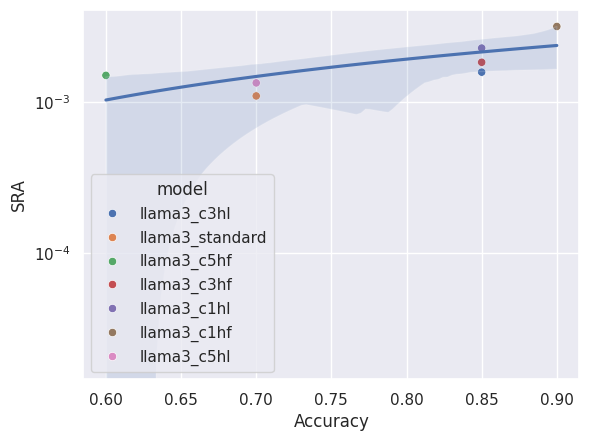

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


sns.scatterplot(df, x='acc', y='sra', hue='model')
sns.regplot(df, x='acc', y='sra', scatter=False)

# for i, row in df.iterrows():
#     plt.text(row['acc'], row['sra'], row['model'])

plt.ylabel('SRA')
plt.xlabel("Accuracy")
plt.yscale('log')

In [5]:
import pickle

with open('../prompting/outputs/mistral7b_full/109_attentions.pkl', 'rb') as f:
    a = pickle.load(f)

In [6]:
t = a['Clarification']
len(t), t[0].shape, len(t[1])

(2, torch.Size([623]), 23)

In [7]:
t[1][2].shape

torch.Size([603])

In [59]:
from glob import glob
import pandas as pd


res_files = glob('data/eval4/*.json')

res_df_list = []

for f in res_files:
    model_name = f.split('/')[-1].replace(".json", "")
    correct = 0
    sra = 0
    resps = load_responses(f)
    print("no of instances:", len(resps))
    
    for r in resps:
        if r['strategy'] == r['inferred_strategy']:
            correct = 1
        else:
            correct = 0
        res_df_list.append({
            'correct': correct,
            'turns': len(r['messages']),
            'model': model_name,
            'sra': r['sra']
        })

df = pd.DataFrame(res_df_list)
df.sort_values(by=['sra'])

no of instances: 20
no of instances: 20
no of instances: 20
no of instances: 20
no of instances: 20
no of instances: 20
no of instances: 20


,correct,turns,model,sra
23,0,19,llama3_standard,0.000257
39,0,17,llama3_standard,0.000321
123,1,19,llama3_c5hl,0.000352
139,0,17,llama3_c5hl,0.000369
3,1,19,llama3_c3hl,0.000373
...,...,...,...,...
108,1,11,llama3_c1hf,0.004183
106,1,19,llama3_c1hf,0.004272
116,1,21,llama3_c1hf,0.004417
109,1,19,llama3_c1hf,0.004658


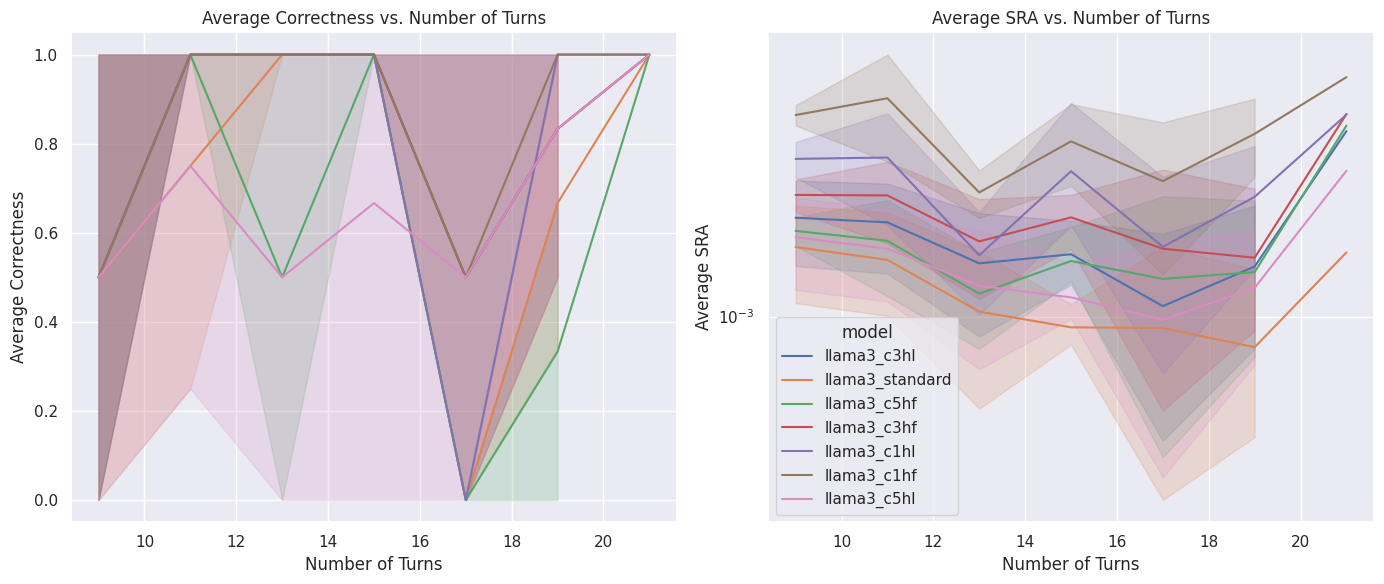

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate average correctness and SRA for each model and number of turns
avg_correctness = df.groupby(['model', 'turns'])['correct'].mean().reset_index()
avg_sra = df.groupby(['model', 'turns'])['sra'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot average correctness vs. number of turns
sns.lineplot(x='turns', y='correct', hue='model', data=df, ax=axes[0])
axes[0].set_title('Average Correctness vs. Number of Turns')
axes[0].set_ylabel('Average Correctness')
axes[0].set_xlabel('Number of Turns')
axes[0].legend([], [], frameon=False)
# Plot average SRA vs. number of turns
sns.lineplot(x='turns', y='sra', hue='model', data=df, ax=axes[1])
axes[1].set_title('Average SRA vs. Number of Turns')
axes[1].set_ylabel('Average SRA')
axes[1].set_xlabel('Number of Turns')
axes[1].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()


# model based evaluation

In [1]:
import json
from typing import List, Dict
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from deepeval.metrics import GEval, BaseMetric, BiasMetric
from deepeval.utils import set_should_ignore_errors
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from deepeval import evaluate

import torch

/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/deepeval/confident/types.py:7: RuntimeWarning: fields may not start with an underscore, ignoring "_dataset_rank"
  class ConfidentEvaluateRequestData(BaseModel):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/deepeval/confident/types.py:7: RuntimeWarning: fields may not start with an underscore, ignoring "_dataset_alias"
  class ConfidentEvaluateRequestData(BaseModel):
/home/navid/anaconda3/envs/gen/lib/python3.10/site-packages/deepeval/confident/types.py:7: RuntimeWarning: fields may not start with an underscore, ignoring "_dataset_id"
  class ConfidentEvaluateRequestData(BaseModel):


In [2]:
import json

test_file = 'data/eval3/llama2_ft.json'

def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))

    return data

data = load_jsonl(test_file)

In [14]:
def build_test_case(examples):
    test_cases = []
    instructions = []
    for ex in examples:
        # removing system message and last supporter message
        all_messages = [m['content'] for m in ex['messages']]
        messages = all_messages[1:-1]

        sys_msg_instructions = all_messages[0]
 
        case = LLMTestCase(
            input = messages[-1],
            context = messages[:-1],
            actual_output = ex['model_response']
        )
        instructions.append(sys_msg_instructions)
        test_cases.append(case)


    return test_cases, instructions

In [15]:
test_data, instructions = build_test_case(data)
test_dataset = EvaluationDataset(test_data)

## define criteria

In [17]:
strategy_following_criteria = """Judge the out

SyntaxError: invalid syntax (1744958217.py, line 1)